In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Change some pandas display options
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 2000)
pd.set_option("styler.format.precision", 5)


# Functions


In [3]:
def normalize_json(data):
    spaces_details = pd.json_normalize(data, record_path=["available_dates"], meta=["id"], errors="ignore")

    # Change columns type
    spaces_details["start"] = spaces_details["start"].astype("datetime64[ns]")
    spaces_details["end"] = spaces_details["end"].astype("datetime64[ns]")
    spaces_details["cancellable"] = spaces_details["cancellable"].astype(int)

    # Split date from time
    spaces_details["date"] = spaces_details["start"].dt.to_period("d").astype("datetime64[ns]")
    # spaces_details["date"] = spaces_details["date"].astype("str")

    return spaces_details


def add_cancellable_percent(spaces_details: pd.DataFrame):
    # Add new cancellable percentage column
    spaces_details["cancellable_percent"] = spaces_details["cancellable"] * spaces_details["total_time_span"]
    spaces_details["cancellable_percent"] /= spaces_details["total_time_span"].sum()

    # Drop columns
    spaces_details.drop(columns="cancellable", inplace=True)

    return spaces_details


def encode_time_span(spaces_details: pd.DataFrame):
    def encode(row: pd.Series):
        if row["end"].hour == 23:
            end = row["end"].hour
        else:
            end = row["end"].hour - 1
        start = row["start"].hour

        row.loc[start:end] = 1
        return row

    zeros_matrix = np.zeros(shape=(spaces_details.shape[0], 24), dtype="int")

    zeros_matrix = pd.DataFrame(zeros_matrix, columns=[i for i in range(24)])

    spaces_details = pd.concat([spaces_details, zeros_matrix], axis=1)

    return spaces_details.apply(encode, axis=1)


def add_total_time_span(spaces_details: pd.DataFrame):
    # Get available time span for each date
    # spaces_details["time_span"] = (spaces_details["end"] - spaces_details["start"]).astype("timedelta64[h]")
    spaces_details["total_time_span"] = spaces_details.loc[:, 0:23].sum(axis=1)

    # Correct time span to be 24 for whole day
    # spaces_details["time_span"] = spaces_details["time_span"].apply(lambda x: x + 1 if x == 23 else x)
    return spaces_details


# Read json data


In [4]:
with open("../data/raw/spaces_dummy_data.json", mode="r") as f:
    data = json.load(f)
    


# Normalize data


In [5]:
spaces_details = normalize_json(data)
spaces_details = encode_time_span(spaces_details)
spaces_details = add_total_time_span(spaces_details)
spaces_details = add_cancellable_percent(spaces_details)


In [6]:
spaces_details_styled = spaces_details.style.applymap(lambda x: 'color:darkorange' if x==1 else None)
spaces_details_styled

,start,end,id,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,total_time_span,cancellable_percent
0,2022-01-01 08:00:00,2022-01-01 11:00:00,A1,2022-01-01 00:00:00,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.01613
1,2022-01-01 14:00:00,2022-01-01 18:00:00,A1,2022-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,4,0.02151
2,2022-01-02 00:00:00,2022-01-02 23:59:59,A1,2022-01-02 00:00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,24,0.00000
3,2022-01-03 10:00:00,2022-01-03 15:00:00,A1,2022-01-03 00:00:00,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,5,0.00000
4,2022-01-04 00:00:00,2022-01-04 23:59:00,A1,2022-01-04 00:00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,24,0.00000
5,2022-01-05 08:00:00,2022-01-05 14:00:00,A1,2022-01-05 00:00:00,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,6,0.03226
6,2022-01-01 00:00:00,2022-01-01 23:59:00,A2,2022-01-01 00:00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,24,0.00000
7,2022-01-02 09:00:00,2022-01-02 14:00:00,A2,2022-01-02 00:00:00,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,0.02688
8,2022-01-03 00:00:00,2022-01-03 23:59:00,A2,2022-01-03 00:00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,24,0.12903
9,2022-01-04 11:00:00,2022-01-04 17:00:00,A2,2022-01-04 00:00:00,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,6,0.00000


# First step

1. Get entire time span for each space
2. Check if one of them cover the intended request


In [7]:
individual_spaces = spaces_details.groupby(["id"]).sum()[["total_time_span", "cancellable_percent"]]
individual_spaces = individual_spaces.sort_values('total_time_span', ascending=False)
unique_spaces = individual_spaces.index
individual_spaces

C:\Users\user\AppData\Local\Temp\ipykernel_1500\3697183034.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  individual_spaces = spaces_details.groupby(["id"]).sum()[["total_time_span", "cancellable_percent"]]


,total_time_span,cancellable_percent
id,,
A2,83,0.155914
A1,66,0.069892
A3,37,0.059140


# Second step

- Create combinations from available spaces


In [8]:
spaces_details_group = spaces_details.groupby(["id", "date"]).sum()
# unique_spaces = spaces_details_group.index.levels[0]
unique_dates = spaces_details_group.index.levels[1]


C:\Users\user\AppData\Local\Temp\ipykernel_1500\3019337860.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  spaces_details_group = spaces_details.groupby(["id", "date"]).sum()


In [9]:
import itertools

combinations_lst = list(
    itertools.chain.from_iterable(itertools.combinations(unique_spaces, r) for r in range(2, len(unique_spaces) + 1))
)
combinations_lst


[('A2', 'A1'), ('A2', 'A3'), ('A1', 'A3'), ('A2', 'A1', 'A3')]

In [10]:
df = spaces_details_group.copy()


for comb in combinations_lst:
    dd = pd.DataFrame(spaces_details.query("id in @comb").groupby("date").sum(numeric_only=True))
    
    dd[(dd>1)] = 1
    
    dd = pd.concat({"".join(comb): dd}, names=['id'])

    df = pd.concat([df, dd], axis=0)
    
df['total_time_span'] = df.loc[:, 0:23].sum(axis=1)
df_styled = df.style.applymap(lambda x: 'color:darkorange' if x==1 else None, subset=list(range(0,24)))
# df.reset_index(level=1, inplace=True)
# df['date'] = df['date'].astype(str)
# df.set_index('date', append=True, inplace=True)


In [11]:
# Convert multiindex dataframe to json
# data = {level: df.xs(level).to_dict("index") for level in df.index.levels[0]}
# D = spaces_details_group.groupby(level=0).apply(lambda df: df.xs(df.name).to_dict()).to_dict()

# with open("./jsdf.json", mode="w") as f:
#     json.dump(data, f, indent=4)



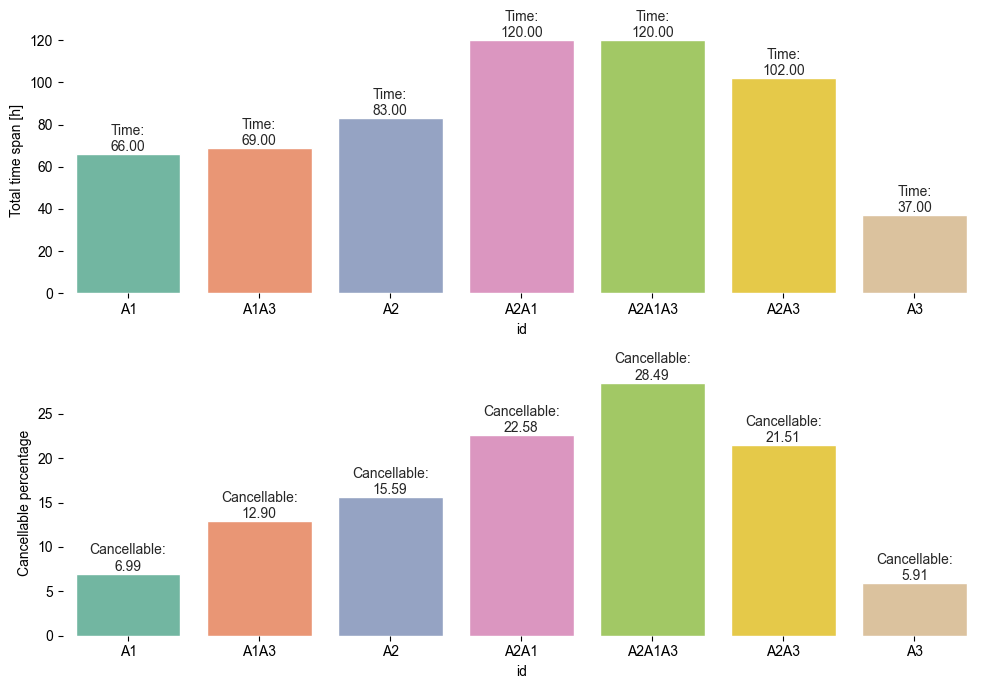

In [12]:
# Get total time span
combinations_time_span = df.reset_index().groupby('id')[['total_time_span', 'cancellable_percent']].sum()
combinations_time_span['cancellable_percent'] *= 100
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

sns.set_style("ticks",{'axes.grid' : True})
sns.barplot(x=combinations_time_span.index, y='total_time_span', data=combinations_time_span, palette='Set2', ax=ax[0])
sns.barplot(x=combinations_time_span.index, y='cancellable_percent', data=combinations_time_span, palette='Set2', ax=ax[1])
sns.despine(bottom = True, left = True)


ax[0].bar_label(ax[0].containers[-1], fmt='Time:\n%.2f', label_type='edge')
ax[1].bar_label(ax[1].containers[-1], fmt='Cancellable:\n%.2f', label_type='edge')
ax[0].set(ylabel='Total time span [h]')
ax[1].set(ylabel='Cancellable percentage')
fig.tight_layout()
